In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings, random, cv2
warnings.filterwarnings("ignore")
import tensorflow as tf
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.utils import load_img, plot_model
from keras.layers import Conv2D, Flatten, Dropout, Dense, MaxPooling2D, BatchNormalization
import os



2022-12-15 22:49:03.635791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 22:49:03.710198: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/san/ml/my_env/lib/python3.8/site-packages/cv2/../../lib64:
2022-12-15 22:49:03.710209: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-15 22:49:04.093956: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerro

In [3]:
train_dir = "../technical_skills/archive/train/train/"
test_dir = "../technical_skills/archive/test/test/"

In [4]:
def import_images(directory):
    image_paths = []
    labels = []
    
    for category in os.listdir(directory):
        for filename in os.listdir(directory+category):
            image_path = os.path.join(directory,category,filename)
            image_paths.append(image_path)
            labels.append(category)
        
    return image_paths, labels

In [5]:
train = pd.DataFrame()
train["image"], train["label"] = import_images(train_dir)
train = train.sample(frac=1).reset_index(drop=True)
train.head()

,image,label
0,../Assessment/archive/train/train/surprise/Tra...,surprise
1,../Assessment/archive/train/train/sad/Training...,sad
2,../Assessment/archive/train/train/happy/Traini...,happy
3,../Assessment/archive/train/train/neutral/Trai...,neutral
4,../Assessment/archive/train/train/angry/Traini...,angry


In [6]:
test = pd.DataFrame()
test["image"], test["label"] = import_images(test_dir)
test.head()

,image,label
0,../Assessment/archive/test/test/happy/PublicTe...,happy
1,../Assessment/archive/test/test/happy/PrivateT...,happy
2,../Assessment/archive/test/test/happy/PublicTe...,happy
3,../Assessment/archive/test/test/happy/PublicTe...,happy
4,../Assessment/archive/test/test/happy/PublicTe...,happy


## **Exploring the Data and Visualize it**

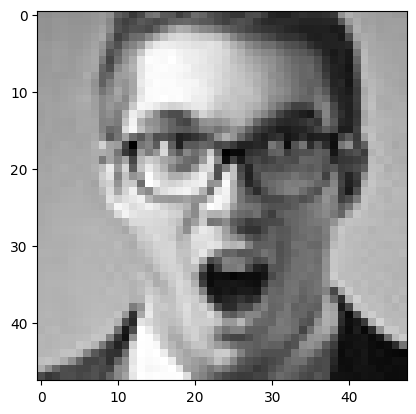

In [7]:
img = Image.open(train["image"][0])
plt.imshow(img,cmap="gray");

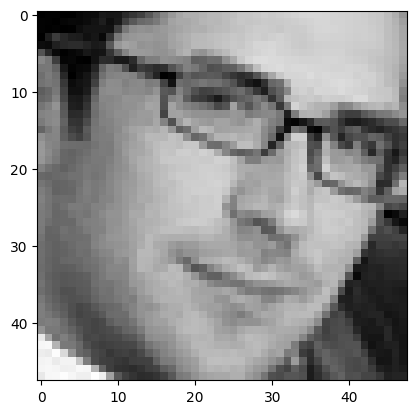

In [8]:
img = Image.open(train["image"][232])
plt.imshow(img,cmap="gray");

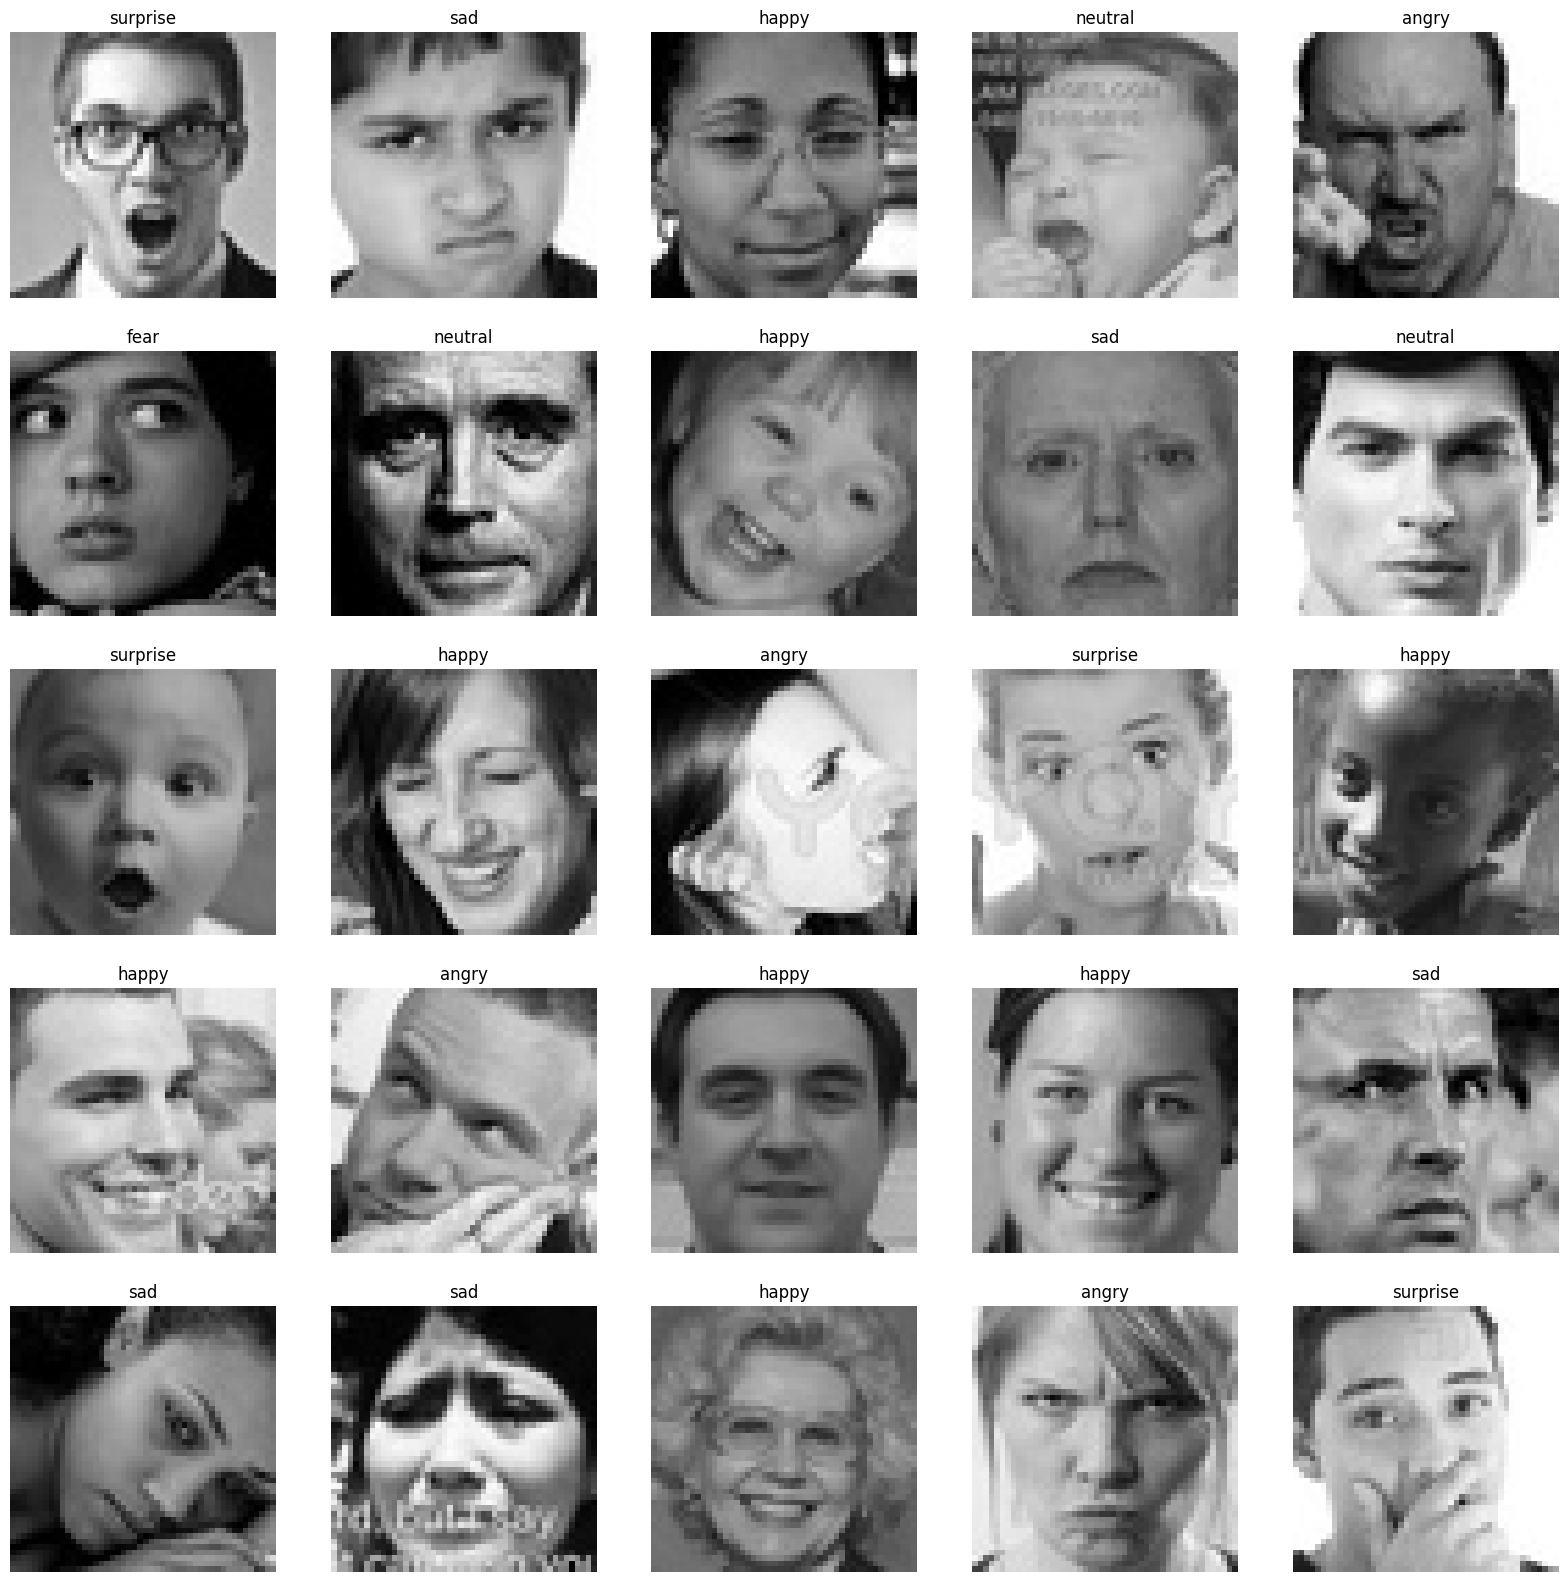

In [9]:
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for idx, file, label in files.itertuples():
    plt.subplot(5,5,idx+1)
    image = load_img(file)
    image = np.array(image)
    plt.imshow(image,cmap="gray")
    plt.title(label)
    plt.axis("off")

## **Check if there are any Gaps in the Data**

<AxesSubplot: >

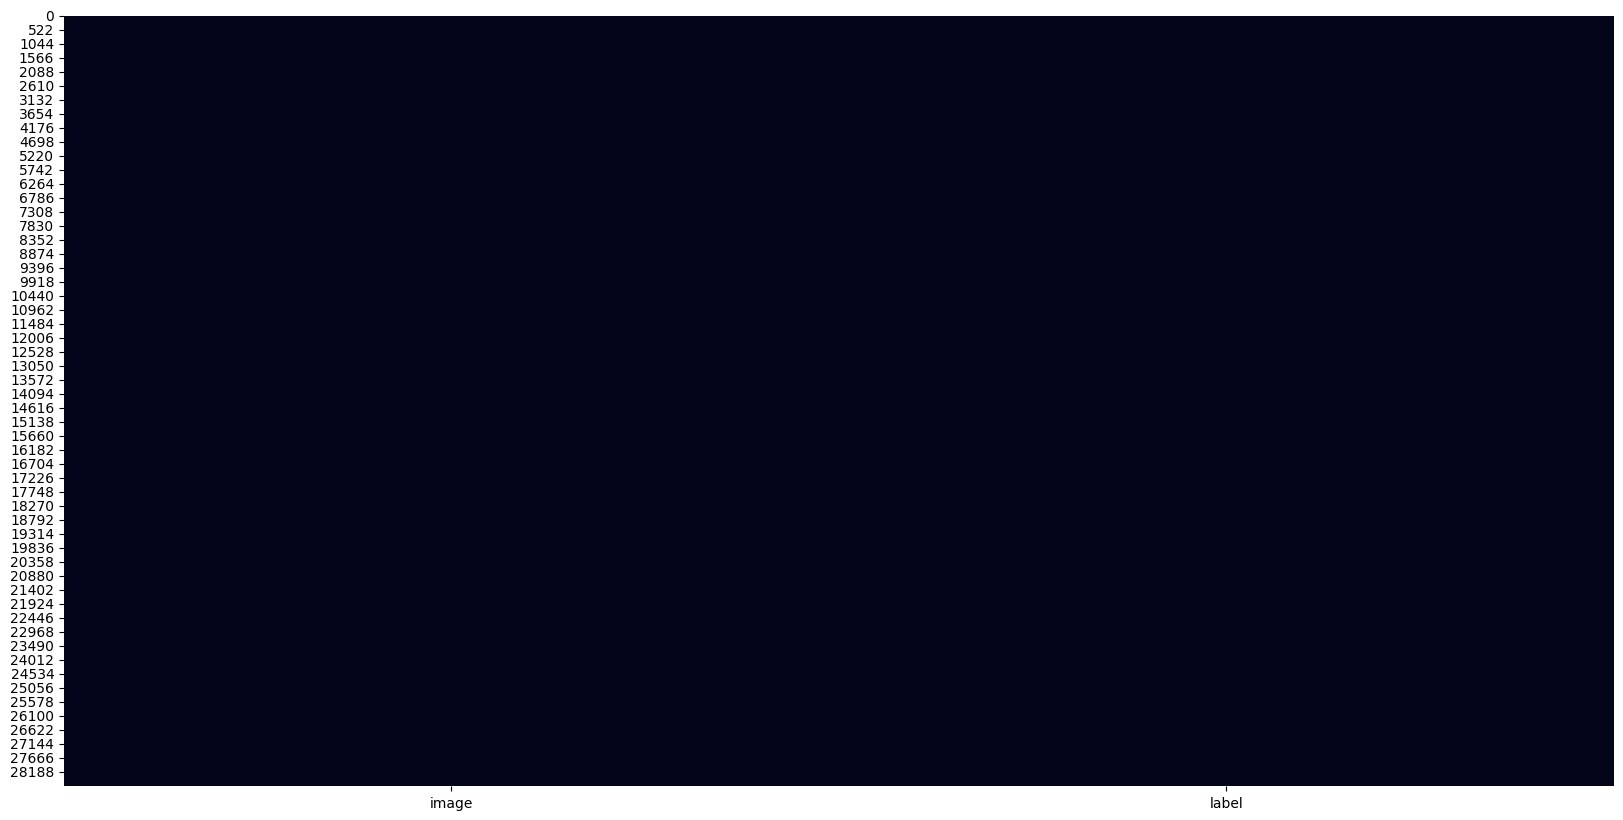

In [10]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(train.isnull(), cbar=False, ax=ax)

<AxesSubplot: >

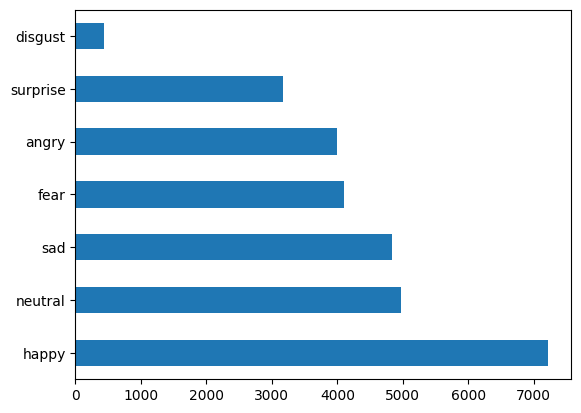

In [11]:
train["label"].value_counts().plot(kind="barh")

## **Feature Extraction**

In [12]:
def extract_features(images):
    features = []
    
    for file in tqdm(images):
        img = load_img(file,grayscale=True)
        img = np.array(img)
        features.append(img)
    
    features = np.array(features).reshape(len(features),48,48,1)
    return features

In [13]:
feat_train = extract_features(train["image"])
feat_test = extract_features(test["image"])

  0%|          | 0/28709 [00:00<?, ?it/s]

  0%|          | 0/7178 [00:00<?, ?it/s]

***Normalize the images***

In [14]:
X_train = feat_train / 255.
X_test = feat_test / 255.

***Convert labels to integers***

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(train["label"])
y_test = le.transform(test["label"])

In [16]:
y_train = to_categorical(y_train,num_classes=7)
y_test = to_categorical(y_test,num_classes=7)

## **CNN Model Architecture**

In [17]:
cnn = Sequential()

# 1st Convolutional Layer
cnn.add(Conv2D(filters=128,kernel_size=(3,3),activation="relu",input_shape=(48,48,1)))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.3))

# 2nd Convolutional Layer
cnn.add(Conv2D(filters=256,kernel_size=(3,3),activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))

# 3rd Convolutional Layer
cnn.add(Conv2D(filters=512,kernel_size=(3,3),activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.3))

# 4th Convolutional Layer
cnn.add(Conv2D(filters=512,kernel_size=(3,3),activation="relu"))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.32))

# Flatten
cnn.add(Flatten())

# 1st Fully-Connected Layer
cnn.add(Dense(units=512,activation="relu"))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.3))

# 2nd Fully-Connected Layer
cnn.add(Dense(units=512,activation="relu"))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))

# Output Layer
cnn.add(Dense(units=7,activation="softmax"))

2022-12-15 22:49:09.111759: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 22:49:09.111875: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/san/ml/my_env/lib/python3.8/site-packages/cv2/../../lib64:
2022-12-15 22:49:09.111914: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/san/ml/my_env/lib/python3.8/site-packages/cv2/../../lib64:
2022-12-15 22:49:09.111944: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load

In [18]:
cnn.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [19]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 23, 23, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 256)      0

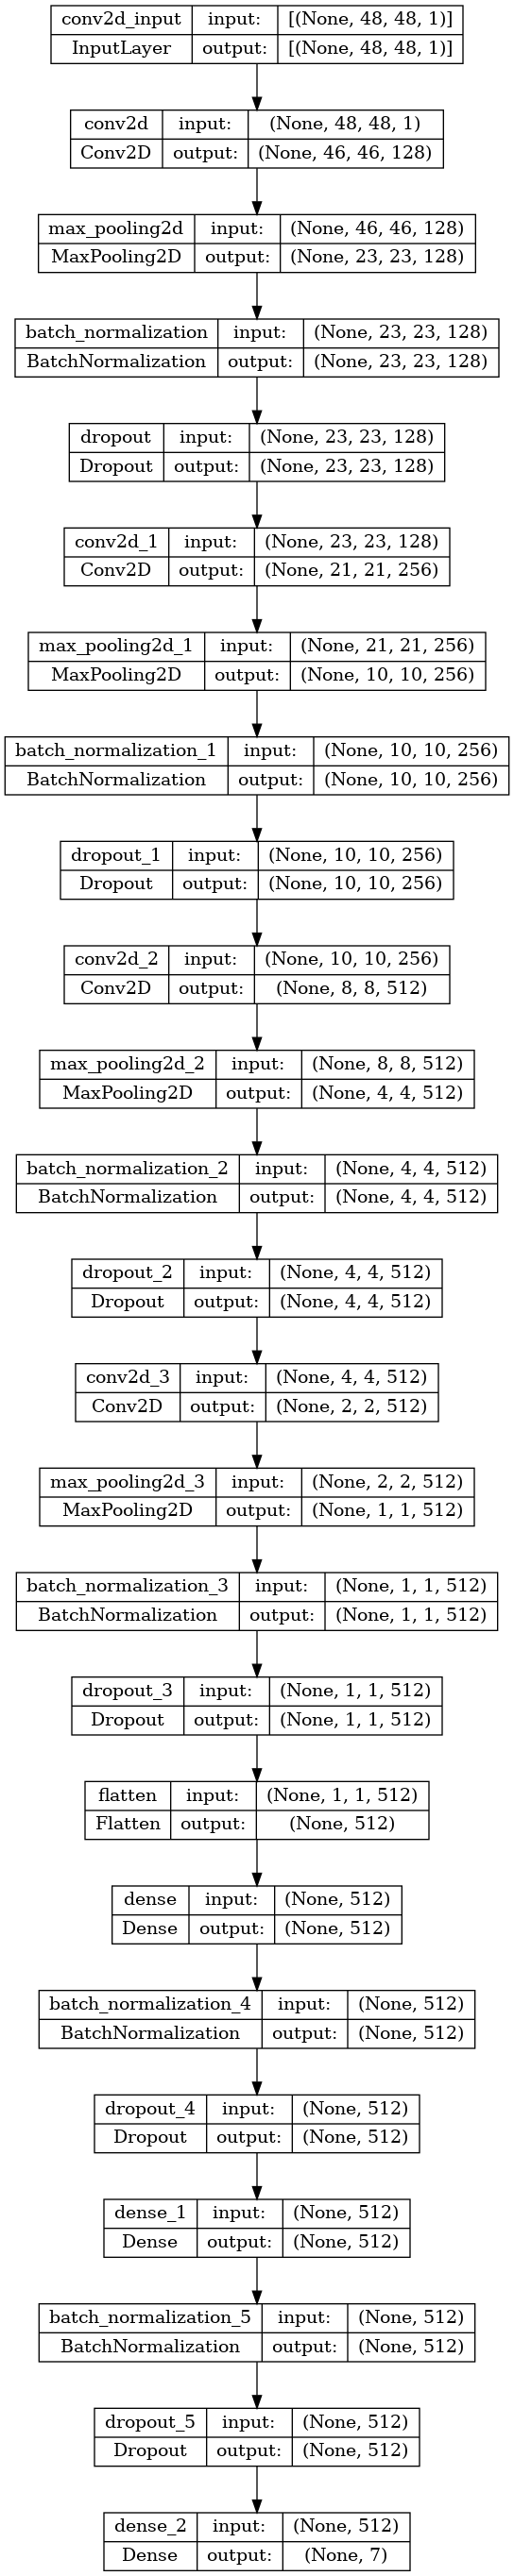

In [20]:
from IPython.display import SVG, Image
plot_model(cnn, to_file="model.png", show_shapes=True, show_layer_names=True)
Image("model.png",width=400, height=200)

## **Building model**

In [21]:
r = cnn.fit(x=X_train,y=y_train,batch_size=128,epochs=5,validation_data=(X_test,y_test))

Epoch 1/5
225/225 [==============================] - 130s 571ms/step - loss: 2.0218 - accuracy: 0.2647 - val_loss: 1.9538 - val_accuracy: 0.2471
Epoch 2/5
225/225 [==============================] - 128s 571ms/step - loss: 1.5386 - accuracy: 0.4185 - val_loss: 1.5590 - val_accuracy: 0.3731
Epoch 3/5
225/225 [==============================] - 127s 567ms/step - loss: 1.3281 - accuracy: 0.4950 - val_loss: 1.3808 - val_accuracy: 0.4628
Epoch 4/5
225/225 [==============================] - 129s 572ms/step - loss: 1.2073 - accuracy: 0.5435 - val_loss: 1.2622 - val_accuracy: 0.5135
Epoch 5/5
225/225 [==============================] - 127s 565ms/step - loss: 1.1291 - accuracy: 0.5691 - val_loss: 1.1265 - val_accuracy: 0.5773


## **Model Performance & Error Analysis**

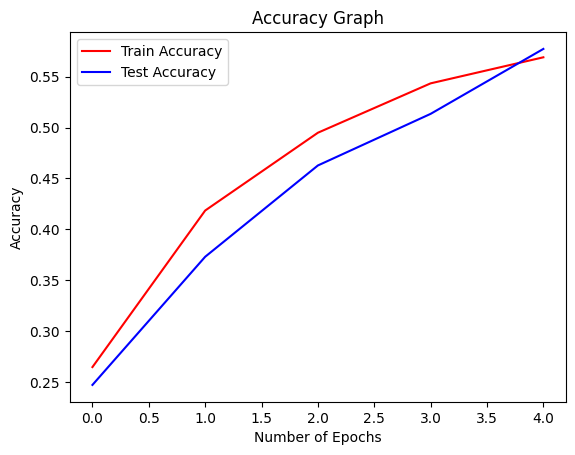

In [22]:
accuracy = r.history["accuracy"]
val_accuracy = r.history["val_accuracy"]
epochs = range(len(accuracy))

plt.plot(epochs,accuracy,"r",label="Train Accuracy")
plt.plot(epochs,val_accuracy,"b",label="Test Accuracy")
plt.title("Accuracy Graph")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend();

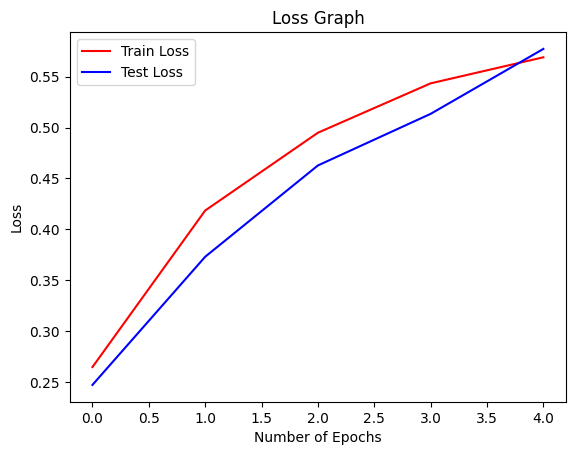

In [23]:
loss = r.history["loss"]
val_loss = r.history["val_loss"]
epochs = range(len(loss))

plt.plot(epochs,accuracy,"r",label="Train Loss")
plt.plot(epochs,val_accuracy,"b",label="Test Loss")
plt.title("Loss Graph")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend();

In [24]:
preds_op=[]
for i, row in tqdm(test.iterrows(), total=len(test)):
    pred = cnn.predict(X_test[i].reshape(1, 48, 48, 1))
    prediction_label = le.inverse_transform([pred.argmax()])[0]
    preds_op.append(prediction_label)

  0%|          | 0/7178 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 13ms/step


In [25]:
from sklearn.metrics import classification_report
print(classification_report(test.label,preds_op,target_names=["surprise"
                                                              ,"fear","angry"
                                                              ,"neutral","sad"
                                                              ,"disgust","happy"]))

              precision    recall  f1-score   support

    surprise       0.53      0.44      0.48       958
        fear       0.56      0.37      0.45       111
       angry       0.61      0.11      0.19      1024
     neutral       0.79      0.82      0.80      1774
         sad       0.45      0.68      0.54      1233
     disgust       0.42      0.57      0.48      1247
       happy       0.76      0.69      0.72       831

    accuracy                           0.58      7178
   macro avg       0.59      0.52      0.52      7178
weighted avg       0.60      0.58      0.56      7178



In [26]:
df_compare = pd.DataFrame()
df_compare["predicted"] = preds_op
df_compare["Actual"] = test.label
df_compare.loc[df_compare["predicted"] == df_compare["Actual"] , "is_correct"] = 1
df_compare.loc[df_compare["predicted"] != df_compare["Actual"] , "is_correct"] = 0
df_compare

,predicted,Actual,is correct
0,happy,happy,1.0
1,happy,happy,1.0
2,happy,happy,1.0
3,neutral,happy,0.0
4,happy,happy,1.0
...,...,...,...
7173,sad,sad,1.0
7174,neutral,sad,0.0
7175,sad,sad,1.0
7176,angry,sad,0.0


<AxesSubplot: >

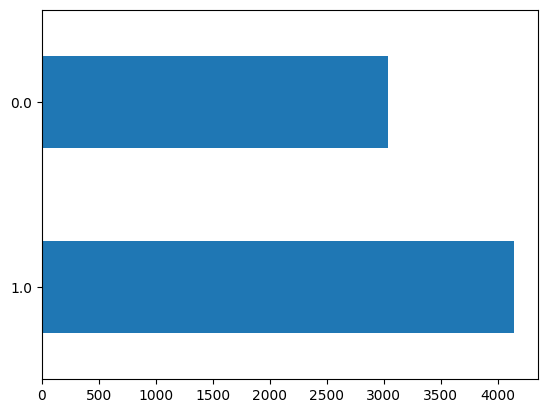

In [27]:
df_compare["is_correct"].value_counts().plot(kind="barh")

**Based on the above analysis and graph we can tell that to improve the model we need to try to work on in those suggestions:**

1- The limitation in this model training was in the number of "Epochs" was not enough and that explains the "Accuracy Graph" & "Loss Graph". The reason for that was the computational power.

2- Data sample balancing, when we look at the data we will find some classes did not have enough data like (disgust), and this may cause some noise in the model.

***Saving the model***

In [29]:
model_json = cnn.to_json()
cnn.save("facial_expression_net.h5")
with open("facial_expression_model.json", "w") as json_file:
    json_file.write(model_json)

## **Test with an image of Test data**

In [30]:
#load The model
model = tf.keras.models.load_model("facial_expression_net.h5")

#load the images
ex_dir = "../technical_skills/archive/test/test/"
ex_df = pd.DataFrame()

def import_images(directory):
    image_paths = []
    labels = []
    
    for category in os.listdir(directory):
        for filename in os.listdir(directory+category):
            image_path = os.path.join(directory,category,filename)
            image_paths.append(image_path)
            labels.append(category)
        
    return image_paths, labels

ex_df["image"], ex_df["label"] = import_images(ex_dir)


#Feature Extraction
def extract_features(images):
    features = []
    
    for file in tqdm(images):
        img = load_img(file,grayscale=True)
        img = np.array(img)
        features.append(img)
    
    features = np.array(features).reshape(len(features),48,48,1)
    return features

feat_ex = extract_features(ex_df["image"])


#Normalize
feat_ex = feat_ex / 255.



  0%|          | 0/7178 [00:00<?, ?it/s]

### ***Start Testing using test file images***

Original Label: angry
1/1 [==============================] - 0s 89ms/step
Predicted Label: angry


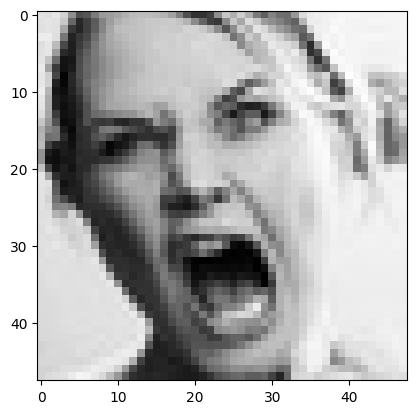

In [31]:
img_idx = random.randint(0,len(ex_df))
print("Original Label:", ex_df["label"][img_idx])
pred = model.predict(X_test[img_idx].reshape(1,48,48,1))
predicted_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Label:", predicted_label)
plt.imshow(X_test[img_idx].reshape(48,48),cmap="gray");

Original Label: happy
1/1 [==============================] - 0s 13ms/step
Predicted Label: happy


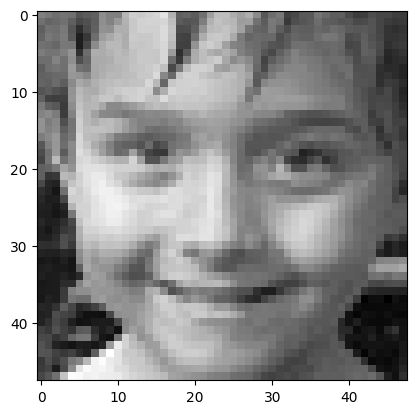

In [32]:
img_idx = random.randint(0,len(ex_df))
print("Original Label:", ex_df["label"][img_idx])
pred = model.predict(X_test[img_idx].reshape(1,48,48,1))
predicted_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Label:", predicted_label)
plt.imshow(X_test[img_idx].reshape(48,48),cmap="gray");

### ***Start Testing Useing your Machine Camera***

In [2]:
from tensorflow.keras.models import model_from_json
import numpy as np

import tensorflow as tf


class FacialExpressionModel(object):

    EMOTIONS_LIST = ["Angry", "Disgust",
                    "Fear", "Happy",
                    "Neutral", "Sad",
                    "Surprise"]

    def __init__(self, model_json_file, model_weights_file):
        # load model from JSON file
        with open(model_json_file, "r") as json_file:
            loaded_model_json = json_file.read()
            self.loaded_model = model_from_json(loaded_model_json)

        # load weights into the new model
        self.loaded_model.load_weights(model_weights_file)
        self.loaded_model.make_predict_function()

    def predict_emotion(self, img):
        self.preds = self.loaded_model.predict(img)
        return FacialExpressionModel.EMOTIONS_LIST[np.argmax(self.preds)]

2022-12-15 23:13:18.143070: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 23:13:18.230994: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-15 23:13:18.231006: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-15 23:13:18.681664: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

## Getting frames and doing prediction

In [3]:
  
import cv2
import numpy as np

facec = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
model = FacialExpressionModel("./facial_expression_model.json", "facial_expression_net.h5")
font = cv2.FONT_HERSHEY_SIMPLEX

class VideoCamera(object):
    def __init__(self):
        self.video = cv2.VideoCapture(0)

    def __del__(self):
        self.video.release()

    # returns camera frames along with bounding boxes and predictions
    def get_frame(self):
        _, fr = self.video.read()
        gray_fr = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
        faces = facec.detectMultiScale(gray_fr, 1.3, 5)

        for (x, y, w, h) in faces:
            fc = gray_fr[y:y+h, x:x+w]

            roi = cv2.resize(fc, (48, 48))
            pred = model.predict_emotion(roi[np.newaxis, :, :, np.newaxis])

            cv2.putText(fr, pred, (x, y), font, 1, (255, 255, 0), 2)
            cv2.rectangle(fr,(x,y),(x+w,y+h),(255,0,0),2)

        return fr

2022-12-15 23:13:20.146329: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 23:13:20.146719: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/san/ml/my_env/lib/python3.8/site-packages/cv2/../../lib64:
2022-12-15 23:13:20.146842: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/san/ml/my_env/lib/python3.8/site-packages/cv2/../../lib64:
2022-12-15 23:13:20.146954: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load

## Function for showing output video

In [4]:
def gen(camera):
    while True:
        frame = camera.get_frame()
        cv2.imshow("Facial Expression",frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    cv2.destroyAllWindows()

In [7]:
gen(VideoCamera())

1/1 [==============================] - 0s 12ms/step


[ WARN:0@71.118] global /io/opencv/modules/videoio/src/cap_v4l.cpp (1013) tryIoctl VIDEOIO(V4L2:/dev/video0): select() timeout.


error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
